# HW2

подключение всего

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV 
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [2]:
sample = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

## Анализ train

Посмотрим что у нас в train

In [3]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


Посмотрим различие в категориальных данных для сего действия строим диаграммы

In [3]:
train.gender.value_counts(normalize=True)

Female    0.589180
Male      0.410486
Other     0.000333
Name: gender, dtype: float64

Видим, что есть три пола, хоть и "Other" почти отсутствует, "Male" меньше, чем "Female", но в мире наоборот мужской части населения больше, чем женской.

In [4]:
train.hypertension.value_counts(normalize=True)

0    0.90547
1    0.09453
Name: hypertension, dtype: float64

Из этой серии мы можем сделать вывод, что гипертонией страдают около 9.5%, а в мире 16-30%

In [5]:
train.heart_disease.value_counts(normalize=True)

0    0.952168
1    0.047832
Name: heart_disease, dtype: float64

Здесь видно что около 5% страдают от сердечной не достаточности

In [6]:
train.ever_married.value_counts(normalize=True)

Yes    0.645845
No     0.354155
Name: ever_married, dtype: float64

Тут мы видем что 2/3 опрошенных были женаты

In [7]:
train.work_type.value_counts(normalize=True)

Private          0.573981
Self-employed    0.155795
children         0.139595
Govt_job         0.126796
Never_worked     0.003833
Name: work_type, dtype: float64

Видно, что не работающих всего 0,3% от выборки, при этом около 57% решили не говорить где работают

In [8]:
train.Residence_type.value_counts(normalize=True)

Urban    0.500917
Rural    0.499083
Name: Residence_type, dtype: float64

Видно, что поделены почти поровну

In [9]:
train['smoking_status'] = train['smoking_status'].fillna('no data')
test['smoking_status'] = test['smoking_status'].fillna('no data')
train.smoking_status.value_counts(normalize=True)

never smoked       0.369288
no data            0.305856
formerly smoked    0.172761
smokes             0.152095
Name: smoking_status, dtype: float64

Тут мы видим что у нас много отсутствующей информации(около 30,5%)

А теперь посмотрим распределение числовых данных, для начала добавим среднее значение bmi к Nan.

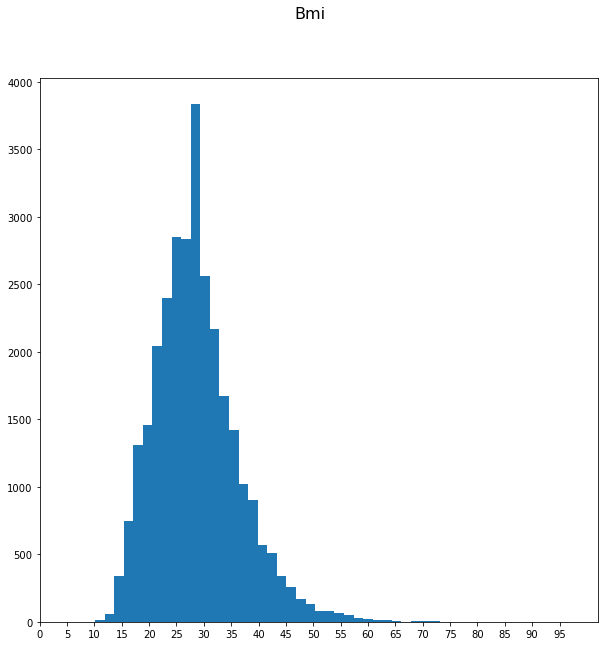

In [19]:
mean_bmi = train['bmi'].mean()
train['bmi'] = train['bmi'].fillna(mean_bmi)
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Bmi', fontsize=16)
plt.hist(train.bmi.values,bins=50)
plt.xticks(range(0, 100, 5))
plt.show()

ИМТ лежит в основном между 20 и 30

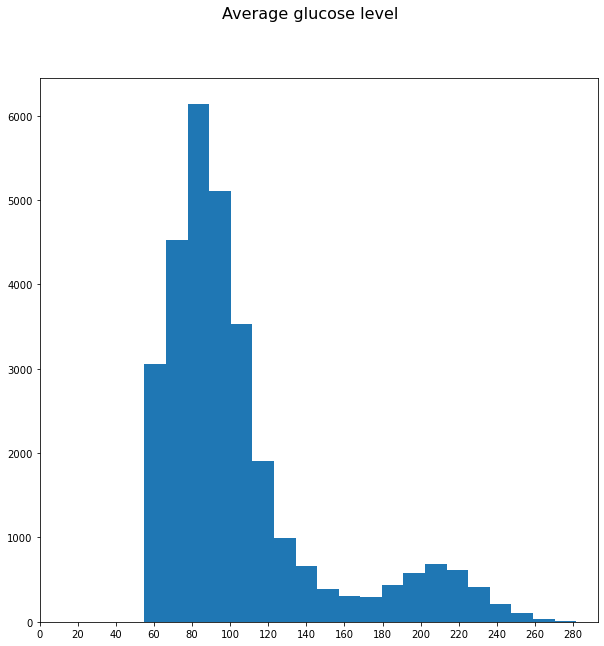

In [21]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Average glucose level', fontsize=16)
plt.hist(train.avg_glucose_level.values,bins=20) 
plt.xticks(range(0, 300, 20))
plt.show()

Хоть мы и не знаем единицы измерения глюкозы в крови, но обычно это мг/л, и по данным из вики норма это 72-99, если больше то у человека диабет, видим, что у большенства в норме, но есть и диабетники

In [32]:
train.avg_glucose_level.where(train.avg_glucose_level > 99).count()

11715

То есть примерно у трети из опрошенных есть диабет

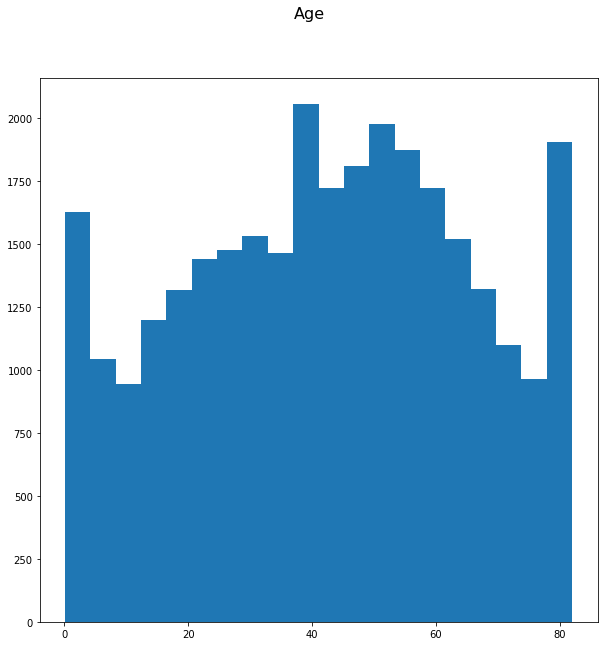

In [21]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Age', fontsize=16)
plt.hist(train.age.values,bins=20) 
plt.show()

Из этой диаграммы мы видем что данные у нас о людях разных возрастов

## Feature generation

Для начала добавим средний ИМТ в тестовый датасет

In [33]:
test['bmi'] = test['bmi'].fillna(mean_bmi) # замещение Nan

Ну и заменим все да/нет на 1/0

In [34]:
ever_married_dict = {'Yes': 1, 'No':0 }
train['ever_married'] =train['ever_married'].replace(ever_married_dict)
test['ever_married'] = test['ever_married'].replace(ever_married_dict)

Проделаем нечто похожее с данными про работу, где 1-i это если мы знаем что то и 0 если нет

In [35]:
for i in train['work_type'].unique():
    train['work_type_is_{}'.format(i)] = (train['work_type'] == i)*1
    test['work_type_is_{}'.format(i)] = (test['work_type'] == i)*1

Тут замения знания о курильщиках на средние значения количества инсультов на тип курильщика

In [36]:
smoking_status_target_enc_dict = (train.groupby(['smoking_status'])['stroke'].agg(['mean'])).to_dict()['mean']
train['smoking_status_target_enc'] = train['smoking_status'].replace(smoking_status_target_enc_dict)
test['smoking_status_target_enc'] = test['smoking_status'].replace(smoking_status_target_enc_dict)
for i in train['smoking_status'].unique():
    train['smoking_status_is_{}'.format(i)] = (train['smoking_status'] == i)*1
    test['smoking_status_is_{}'.format(i)] = (test['smoking_status'] == i)*1

Так же оцифруем знание место проживания

In [37]:
residence_target_enc_dict = (train.groupby(['Residence_type'])['stroke'].agg(['mean'])).to_dict()['mean']
train['residence_target_enc'] = train['Residence_type'].replace(residence_target_enc_dict)
test['residence_target_enc'] = test['Residence_type'].replace(residence_target_enc_dict)
train['Residence_type'] = train['Residence_type'].replace({'Urban':0, 'Rural':1 })
test['Residence_type'] = test['Residence_type'].replace({'Urban':0, 'Rural':1 })

А теперь получим средние количество инсультов на половую принадлежность и добавим категориальные столбцы

In [38]:
gender_target_enc_dict = (train.groupby(['gender'])['stroke'].agg(['mean'])).to_dict()['mean']
train['gender_target_enc'] = train['gender'].replace(gender_target_enc_dict)
test['gender_target_enc'] = test['gender'].replace(gender_target_enc_dict)
for i in train['gender'].unique():
    train['gender_is_{}'.format(i)] = (train['gender'] == i)*1
    test['gender_is_{}'.format(i)] = (test['gender'] == i)*1

Посмотрим на корреляционную таблицу еще раз

In [42]:
cor = train.corr()
cor.style.background_gradient(cmap='coolwarm')

,id,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_is_children,work_type_is_Private,work_type_is_Never_worked,work_type_is_Self-employed,work_type_is_Govt_job,smoking_status_target_enc,smoking_status_is_no data,smoking_status_is_never smoked,smoking_status_is_formerly smoked,smoking_status_is_smokes,residence_target_enc,gender_target_enc,gender_is_Male,gender_is_Female,gender_is_Other
id,1.000000,0.013442,0.009823,0.006829,0.010390,-0.002929,0.022125,0.017264,0.007366,-0.023171,0.010468,0.003001,0.008908,-0.001690,0.016353,-0.018663,0.007300,0.009015,0.004645,0.002929,-0.002288,-0.002129,0.002093,0.000982
age,0.013442,1.000000,0.274369,0.252770,0.689001,-0.003792,0.234806,0.349115,0.152684,-0.638318,0.139042,-0.067300,0.323558,0.118051,0.371383,-0.374952,0.106128,0.242490,0.083195,0.003792,-0.026886,-0.028615,0.028762,-0.004046
hypertension,0.009823,0.274369,1.000000,0.121906,0.177805,0.003555,0.161272,0.153921,0.073425,-0.129489,-0.002030,-0.018199,0.108435,0.023080,0.117109,-0.118540,0.033924,0.076262,0.026224,-0.003555,0.024683,0.024055,-0.023833,-0.005900
heart_disease,0.006829,0.252770,0.121906,1.000000,0.126129,0.003691,0.149709,0.057083,0.101548,-0.089377,-0.005263,-0.013903,0.102257,-0.007957,0.094484,-0.059288,-0.034605,0.082667,0.035553,-0.003691,0.078919,0.080314,-0.080152,-0.004093
ever_married,0.010390,0.689001,0.177805,0.126129,1.000000,-0.003797,0.151777,0.339788,0.069678,-0.543941,0.155254,-0.078130,0.193200,0.139750,0.297520,-0.322222,0.094978,0.170825,0.105967,0.003797,-0.031032,-0.033236,0.033438,-0.005568
Residence_type,-0.002929,-0.003792,0.003555,0.003691,-0.003797,1.000000,0.004940,0.002683,-0.002790,0.003816,-0.002860,-0.004741,0.002258,-0.001305,-0.000043,0.006136,-0.003087,0.006393,-0.010455,-1.000000,-0.001116,-0.000300,0.000163,0.003686
avg_glucose_level,0.022125,0.234806,0.161272,0.149709,0.151777,0.004940,1.000000,0.181794,0.087426,-0.111774,0.009976,-0.014092,0.079624,0.017426,0.104047,-0.094419,0.012353,0.074407,0.026217,-0.004940,0.034690,0.034044,-0.033771,-0.007260
bmi,0.017264,0.349115,0.153921,0.057083,0.339788,0.002683,0.181794,1.000000,0.018494,-0.450905,0.191899,-0.018987,0.084499,0.095882,0.230895,-0.271248,0.108983,0.119922,0.075326,-0.002683,-0.022472,-0.022851,0.022802,0.001249
stroke,0.007366,0.152684,0.073425,0.101548,0.069678,-0.002790,0.087426,0.018494,1.000000,-0.052556,0.003986,-0.008319,0.047045,-0.000914,0.041743,-0.031358,-0.002476,0.035096,0.006616,0.002790,0.010261,0.010000,-0.009908,-0.002449
work_type_is_children,-0.023171,-0.638318,-0.129489,-0.089377,-0.543941,0.003816,-0.111774,-0.450905,-0.052556,1.000000,-0.467539,-0.024986,-0.173036,-0.153489,-0.398120,0.515380,-0.236071,-0.166010,-0.169256,-0.003816,0.089502,0.091674,-0.091585,-0.002086


Из этой матрицы корреляции можно видеть, что существует прямая корреляция между Residence_target_enc и типом места жительства, что очевидно, поскольку один признак является производным от другого. Также существует сильная корреляция и статуса брака, и курения. Кроме того, ясно видно, что если функция получена из другого (например, Smoking_status_is ... и Smoking_status_enc_dict), корреляция наблюдается.

Давайте посмотрим на финальную таблицу

In [44]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,...,smoking_status_target_enc,smoking_status_is_no data,smoking_status_is_never smoked,smoking_status_is_formerly smoked,smoking_status_is_smokes,residence_target_enc,gender_target_enc,gender_is_Male,gender_is_Female,gender_is_Other
0,30669,Male,3.0,0,0,0,children,1,95.12,18.0,...,0.011443,1,0,0,0,0.017298,0.019245,1,0,0
1,30468,Male,58.0,1,0,1,Private,0,87.96,39.2,...,0.017240,0,1,0,0,0.018033,0.019245,1,0,0
2,16523,Female,8.0,0,0,0,Private,0,110.89,17.6,...,0.011443,1,0,0,0,0.018033,0.016576,0,1,0
3,56543,Female,70.0,0,0,1,Private,1,69.04,35.9,...,0.027783,0,0,1,0,0.017298,0.016576,0,1,0
4,46136,Male,14.0,0,0,0,Never_worked,1,161.28,19.1,...,0.011443,1,0,0,0,0.017298,0.019245,1,0,0


## Выбор оптимальных гиперпарметров для модели


Для начала поделим тренировочные данные 80:20 для того чтоб были тестовые данные

In [45]:
res = train['stroke']
X_train, X_test, Y_train, Y_test = train_test_split(train, res, test_size=0.2)

Теперь напишем кросс-валидационную функцию, которая возвращает коэф ROC-AUC

In [46]:
def my_cross_validation_for_roc_auc(clf, X, y ,cv=5):
    X = np.array(X.copy())
    y = np.array(y.copy())
    kf = KFold(n_splits=cv)
    kf.get_n_splits(X)
    scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        prediction_on_this_fold = clf.predict_proba(X_test)[:,1]
        score = roc_auc_score(y_score=prediction_on_this_fold, y_true=y_test)
        scores.append(score)
    return scores

In [47]:
features = ['id', 'age', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type', 'avg_glucose_level', 
            'bmi', 'work_type_is_children', 'work_type_is_Private', 'work_type_is_Never_worked',
            'work_type_is_Self-employed', 'work_type_is_Govt_job', 'smoking_status_target_enc',
            'smoking_status_is_no data', 'smoking_status_is_never smoked', 'smoking_status_is_formerly smoked',
            'smoking_status_is_smokes', 'residence_target_enc', 'gender_target_enc',  'gender_is_Male',
            'gender_is_Female', 'gender_is_Other']

### Logistic regression

Воспользуемся логистической регрессией

In [48]:
model = linear_model.SGDClassifier(max_iter=1000,  loss='log', penalty = 'elasticnet')

In [54]:
features_scores = {}
for f in features:
    scores = my_cross_validation_for_roc_auc(model, X_train[[f]] , Y_train)
    print(f,  np.mean(scores))
    features_scores[f] = np.mean(scores)

id 0.4997031875276686
age 0.8292692096243375
hypertension 0.5850080729749911
heart_disease 0.5773462461000753
ever_married 0.6242992728156824
Residence_type 0.5
avg_glucose_level 0.5509119499654556
bmi 0.5118771009567433
work_type_is_children 0.5696825872450936
work_type_is_Private 0.49431466458150064
work_type_is_Never_worked 0.5018239707324059
work_type_is_Self-employed 0.5654908708638244
work_type_is_Govt_job 0.49218924882795695
smoking_status_target_enc 0.5843466068534843
smoking_status_is_no data 0.5543847632164154
smoking_status_is_never smoked 0.494655578004194
smoking_status_is_formerly smoked 0.5479746427598287
smoking_status_is_smokes 0.5139713780377689
residence_target_enc 0.5
gender_target_enc 0.5
gender_is_Male 0.5065830266919212
gender_is_Female 0.5055294257450894
gender_is_Other 0.5


Исходя из этих данных сузим список категорий

In [55]:
features = ['age', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type', 'avg_glucose_level', 
            'work_type_is_children', 'work_type_is_Self-employed', 'work_type_is_Govt_job', 'smoking_status_target_enc',
            'smoking_status_is_no data', 'smoking_status_is_never smoked', 'smoking_status_is_formerly smoked',
            'smoking_status_is_smokes', 'gender_is_Male', 'gender_is_Female']

А теперь выберем оптимальное раздение cv

In [57]:
score = list()
for j in range(2, 20):
    scores = my_cross_validation_for_roc_auc(model, X_train[features] , Y_train, j)
    print(sum(scores) / len(scores), j)
    score.append(sum(scores) / len(scores))
print(max(score))

0.8323495419225573 2
0.8141613953165224 3
0.8315847957676528 4
0.8344119009407807 5
0.8316204216836939 6
0.8282593111150065 7
0.8324682489277775 8
0.8323863414701023 9
0.8327329363866152 10
0.8310755763665056 11
0.8331601981801894 12
0.8276919656256452 13
0.825036204149653 14
0.8141732727674307 15
0.8291199567492793 16
0.8322512249045072 17
0.8307212080820227 18
0.8341983107473908 19
0.8344119009407807


Видно что оптимальнее всего делить на 5 частей

Теперь найдем оптимальные параметры для логистической регрессии, используя GridSearchCV.

In [58]:
model = linear_model.SGDClassifier(loss='log')
X_train = X_train[features]
parameters = { 
     "penalty"        : [ 'l2', 'l1', 'elasticnet'],
     "max_iter" : [ 100, 500, 1000, 1500, 2000, 2500]
        }
grid = GridSearchCV(model, parameters, n_jobs=12, scoring="roc_auc", cv=5, verbose=5)
grid.fit(X_train, Y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:   11.2s
[Parallel(n_jobs=12)]: Done  86 out of  90 | elapsed:   15.7s remaining:    0.6s
[Parallel(n_jobs=12)]: Done  90 out of  90 | elapsed:   16.0s finished


GridSearchCV(cv=5, estimator=SGDClassifier(loss='log'), n_jobs=12,
             param_grid={'max_iter': [100, 500, 1000, 1500, 2000, 2500],
                         'penalty': ['l2', 'l1', 'elasticnet']},
             scoring='roc_auc', verbose=5)

In [59]:
grid.best_estimator_ 

SGDClassifier(loss='log', max_iter=2500, penalty='elasticnet')

Выбираем лучшую оценку и тестируем ее на тренировочных данных, вычисление AUC

In [60]:
model = linear_model.SGDClassifier(loss='log', max_iter=2500, penalty='elasticnet')
model.fit(X_train, Y_train)
X_test = X_test[features]
prediction = model.predict_proba(X_test)
print('Auc score for logistic regression:', roc_auc_score(y_score=prediction[:,1], y_true=Y_test))


Auc score for logistic regression: 0.8766505772699562


Предсказание на тестовых данных

In [61]:
res = model.predict_proba(test[features])

In [62]:
sample['stroke'] = res[:, 1]
sample.to_csv('submit_log_reg.csv', index = None )

### Random forrest классификатор

In [63]:
features = ['age', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type', 'avg_glucose_level', 
            'bmi', 'work_type_is_children', 'work_type_is_Private', 'work_type_is_Never_worked',
            'work_type_is_Self-employed', 'work_type_is_Govt_job', 'smoking_status_target_enc',
            'smoking_status_is_no data', 'smoking_status_is_never smoked', 'smoking_status_is_formerly smoked',
            'smoking_status_is_smokes', 'gender_target_enc',  'gender_is_Male', 'gender_is_Female', 'gender_is_Other']

In [64]:
res = train['stroke']
X_train, X_test, Y_train, Y_test = train_test_split(train, res, test_size=0.2)

Поиск категорий с наибольшим влиянием. Категории малого влияния и с большой корреляцией будет удалены

In [66]:
model = RandomForestClassifier()
features_scores = {}
for f in features:
    scores = my_cross_validation_for_roc_auc(model, X_train[[f]] , Y_train)
    print(f,  np.mean(scores))
    features_scores[f] = np.mean(scores)

age 0.8222429427565002
hypertension 0.5784526387211507
heart_disease 0.5769530920881689
ever_married 0.6288140785996889
Residence_type 0.49919018087551725
avg_glucose_level 0.5088655582935313
bmi 0.5741608638756625
work_type_is_children 0.5684577523477724
work_type_is_Private 0.4837192684970901
work_type_is_Never_worked 0.502120591649682
work_type_is_Self-employed 0.5590419709875054
work_type_is_Govt_job 0.48467480727461904
smoking_status_target_enc 0.5768981147567541
smoking_status_is_no data 0.5495842627991623
smoking_status_is_never smoked 0.47584368481972844
smoking_status_is_formerly smoked 0.5408387283325365
smoking_status_is_smokes 0.516385228696391
gender_target_enc 0.5182831076625295
gender_is_Male 0.5182479878126529
gender_is_Female 0.5181843654759543
gender_is_Other 0.5000636223366987


In [68]:
features = ['age', 'hypertension', 'heart_disease', 'ever_married', 'bmi', 'work_type_is_children',
            'work_type_is_Self-employed', 'smoking_status_target_enc', 'smoking_status_is_no data',
           'smoking_status_is_formerly smoked']
X_train, X_test, Y_train, Y_test = train_test_split(train[features], train['stroke'], test_size=0.2)
cor = X_train.corr()
cor.style.background_gradient(cmap='coolwarm')

,age,hypertension,heart_disease,ever_married,bmi,work_type_is_children,work_type_is_Self-employed,smoking_status_target_enc,smoking_status_is_no data,smoking_status_is_formerly smoked
age,1.000000,0.271696,0.253749,0.690114,0.345522,-0.636859,0.326470,0.370186,-0.373147,0.241828
hypertension,0.271696,1.000000,0.116028,0.179355,0.155976,-0.128714,0.110765,0.119813,-0.116840,0.080578
heart_disease,0.253749,0.116028,1.000000,0.125337,0.056112,-0.089398,0.103192,0.093730,-0.059790,0.081046
ever_married,0.690114,0.179355,0.125337,1.000000,0.337040,-0.542703,0.196242,0.296755,-0.322579,0.170119
bmi,0.345522,0.155976,0.056112,0.337040,1.000000,-0.448290,0.085122,0.230066,-0.271478,0.118963
work_type_is_children,-0.636859,-0.128714,-0.089398,-0.542703,-0.448290,1.000000,-0.173407,-0.398159,0.517088,-0.165723
work_type_is_Self-employed,0.326470,0.110765,0.103192,0.196242,0.085122,-0.173407,1.000000,0.111025,-0.097325,0.087400
smoking_status_target_enc,0.370186,0.119813,0.093730,0.296755,0.230066,-0.398159,0.111025,1.000000,-0.749923,0.841740
smoking_status_is_no data,-0.373147,-0.116840,-0.059790,-0.322579,-0.271478,0.517088,-0.097325,-0.749923,1.000000,-0.303153
smoking_status_is_formerly smoked,0.241828,0.080578,0.081046,0.170119,0.118963,-0.165723,0.087400,0.841740,-0.303153,1.000000


Удаляем информацию о браке, так как она сильно коррелирует с возрастом, а он важнее

Удаляем информацию о куривших раньше, по причине высокой корреляции с подверженных инсульту

In [90]:
features = ['age', 'hypertension', 'heart_disease', 'bmi', 'work_type_is_children',
            'work_type_is_Self-employed', 'smoking_status_target_enc', 'smoking_status_is_no data']
X_train, X_test, Y_train, Y_test = train_test_split(train[features], train['stroke'], test_size=0.2)

Поиск гиперпараметров для модели, возврат их и тестирование на тренировочных данных, прогназирование на тестовых данных

In [71]:
model = RandomForestClassifier()
parameters = {
    "n_estimators" :[10, 25, 50, 100, 150],
    "criterion" :['gini', 'entropy'],
    "max_depth" :[1, 3, 5, 7, 9, None],
    "min_samples_split" :[2, 4, 10, 20],
    "min_samples_leaf" :[1, 3, 5, 7],
    "max_features" :['auto', 'sqrt', 'log2', None]
    
        }
grid = GridSearchCV(model, parameters, n_jobs=14, scoring="roc_auc", cv=3, verbose=5)
grid.fit(X_train, Y_train)

Fitting 3 folds for each of 3840 candidates, totalling 11520 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  44 tasks      | elapsed:    6.9s
[Parallel(n_jobs=14)]: Done 134 tasks      | elapsed:   12.0s
[Parallel(n_jobs=14)]: Done 260 tasks      | elapsed:   19.1s
[Parallel(n_jobs=14)]: Done 422 tasks      | elapsed:   28.5s
[Parallel(n_jobs=14)]: Done 620 tasks      | elapsed:   40.2s
[Parallel(n_jobs=14)]: Done 854 tasks      | elapsed:   55.8s
[Parallel(n_jobs=14)]: Done 1124 tasks      | elapsed:  1.3min
[Parallel(n_jobs=14)]: Done 1430 tasks      | elapsed:  1.6min
[Parallel(n_jobs=14)]: Done 1772 tasks      | elapsed:  2.1min
[Parallel(n_jobs=14)]: Done 2150 tasks      | elapsed:  2.7min
[Parallel(n_jobs=14)]: Done 2564 tasks      | elapsed:  3.4min
[Parallel(n_jobs=14)]: Done 3014 tasks      | elapsed:  4.3min
[Parallel(n_jobs=14)]: Done 3500 tasks      | elapsed:  5.2min
[Parallel(n_jobs=14)]: Done 4022 tasks      | elapsed:  6.4min
[Parallel(n_jobs=14)]: Done 4580 tasks      | e

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=14,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 3, 5, 7, 9, None],
                         'max_features': ['auto', 'sqrt', 'log2', None],
                         'min_samples_leaf': [1, 3, 5, 7],
                         'min_samples_split': [2, 4, 10, 20],
                         'n_estimators': [10, 25, 50, 100, 150]},
             scoring='roc_auc', verbose=5)

In [72]:
grid.best_estimator_

RandomForestClassifier(max_depth=3, max_features='log2', min_samples_split=20,
                       n_estimators=50)

In [91]:
model = RandomForestClassifier(max_depth=3, max_features='log2', min_samples_split=20,
                       n_estimators=50)
model.fit(X_train, Y_train)
X_test = X_test[features]
prediction = model.predict_proba(X_test)
print('Auc score for Random Forrest Classifier:', roc_auc_score(y_score=prediction[:,1], y_true=Y_test))

Auc score for Random Forrest Classifier: 0.8110830415577125


In [92]:
res = model.predict_proba(test[features])
sample['stroke'] = res[:, 1]
sample.to_csv('submit_ran_for.csv', index = None )

### DecisionTreeClassifier

In [75]:
features = ['age', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type', 'avg_glucose_level', 
            'bmi', 'work_type_is_children', 'work_type_is_Private', 'work_type_is_Never_worked',
            'work_type_is_Self-employed', 'work_type_is_Govt_job', 'smoking_status_target_enc',
            'smoking_status_is_no data', 'smoking_status_is_never smoked', 'smoking_status_is_formerly smoked',
            'smoking_status_is_smokes', 'gender_target_enc',  'gender_is_Male', 'gender_is_Female', 'gender_is_Other']

In [76]:
res = train['stroke']
X_train, X_test, Y_train, Y_test = train_test_split(train, res, test_size=0.2)

In [78]:
model = DecisionTreeClassifier()
features_scores = {}
for f in features:
    scores = my_cross_validation_for_roc_auc(model, X_train[[f]] , Y_train)
    print(f,  np.mean(scores))
    features_scores[f] = np.mean(scores)

age 0.8307669544762067
hypertension 0.5833493335744141
heart_disease 0.5777665425942548
ever_married 0.6234852717202342
Residence_type 0.47833904669803856
avg_glucose_level 0.5009567669053588
bmi 0.5711280933799857
work_type_is_children 0.5688586301018022
work_type_is_Private 0.5107283114895189
work_type_is_Never_worked 0.5018459120985461
work_type_is_Self-employed 0.5592572160309397
work_type_is_Govt_job 0.4779038602578291
smoking_status_target_enc 0.5896271460296582
smoking_status_is_no data 0.5563211532529453
smoking_status_is_never smoked 0.5074770627585636
smoking_status_is_formerly smoked 0.5557083306051587
smoking_status_is_smokes 0.5080898854063503
gender_target_enc 0.5125004707550982
gender_is_Male 0.5124020254865199
gender_is_Female 0.5122323178008306
gender_is_Other 0.5001697076856894


In [79]:
features = ['age', 'hypertension', 'heart_disease', 'ever_married', 
            'bmi', 'work_type_is_children', 'work_type_is_Private',
            'work_type_is_Self-employed', 'smoking_status_target_enc',
            'smoking_status_is_no data', 'smoking_status_is_formerly smoked',
            'gender_target_enc',  'gender_is_Male', 'gender_is_Female']
X_train, X_test, Y_train, Y_test = train_test_split(train[features], train['stroke'], test_size=0.2)
cor = X_train.corr()
cor.style.background_gradient(cmap='coolwarm')

,age,hypertension,heart_disease,ever_married,bmi,work_type_is_children,work_type_is_Private,work_type_is_Self-employed,smoking_status_target_enc,smoking_status_is_no data,smoking_status_is_formerly smoked,gender_target_enc,gender_is_Male,gender_is_Female
age,1.000000,0.273642,0.255871,0.688921,0.349142,-0.639979,0.138705,0.325139,0.372785,-0.374721,0.244397,-0.027789,-0.030240,0.030499
hypertension,0.273642,1.000000,0.126887,0.176693,0.155354,-0.130058,-0.001460,0.109925,0.117306,-0.116285,0.078282,0.024230,0.023589,-0.023367
heart_disease,0.255871,0.126887,1.000000,0.128622,0.057077,-0.091057,-0.005773,0.104157,0.092304,-0.060757,0.078379,0.076306,0.077614,-0.077450
ever_married,0.688921,0.176693,0.128622,1.000000,0.340302,-0.544708,0.153118,0.193509,0.298673,-0.321073,0.172148,-0.033990,-0.037374,0.037752
bmi,0.349142,0.155354,0.057077,0.340302,1.000000,-0.454158,0.193139,0.086247,0.230341,-0.268649,0.119742,-0.025549,-0.026189,0.026166
work_type_is_children,-0.639979,-0.130058,-0.091057,-0.544708,-0.454158,1.000000,-0.468832,-0.173755,-0.400018,0.515546,-0.168328,0.091720,0.094254,-0.094212
work_type_is_Private,0.138705,-0.001460,-0.005773,0.153118,0.193139,-0.468832,1.000000,-0.499200,0.161081,-0.240470,0.039298,-0.054517,-0.054634,0.054386
work_type_is_Self-employed,0.325139,0.109925,0.104157,0.193509,0.086247,-0.173755,-0.499200,1.000000,0.105582,-0.090818,0.083279,-0.000151,-0.001967,0.002258
smoking_status_target_enc,0.372785,0.117306,0.092304,0.298673,0.230341,-0.400018,0.161081,0.105582,1.000000,-0.751119,0.840691,-0.001234,0.002123,-0.002669
smoking_status_is_no data,-0.374721,-0.116285,-0.060757,-0.321073,-0.268649,0.515546,-0.240470,-0.090818,-0.751119,1.000000,-0.303098,0.060453,0.060594,-0.060320


In [80]:
features = ['age', 'hypertension', 'heart_disease', 'bmi', 'work_type_is_Private','work_type_is_Self-employed', 
            'smoking_status_target_enc', 'smoking_status_is_no data',
            'gender_target_enc',  'gender_is_Male', 'gender_is_Female']
X_train, X_test, Y_train, Y_test = train_test_split(train[features], train['stroke'], test_size=0.2)

In [84]:
model = DecisionTreeClassifier()
parameters = {
    'splitter': ['best', 'random'],
    "criterion" :['gini', 'entropy'],
    "max_depth" :[1, 3, 5, 7, 9, None],
    "min_samples_split" :[2, 4, 10, 20],
    "min_samples_leaf" :[1, 3, 5, 7],
    "max_features" :['auto', 'sqrt', 'log2', None]
    
        }
grid = GridSearchCV(model, parameters, n_jobs=14, scoring="roc_auc", cv=5, verbose=5)
grid.fit(X_train, Y_train)

Fitting 5 folds for each of 1536 candidates, totalling 7680 fits


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  44 tasks      | elapsed:    4.2s
[Parallel(n_jobs=14)]: Done 134 tasks      | elapsed:    5.4s
[Parallel(n_jobs=14)]: Done 260 tasks      | elapsed:    6.9s
[Parallel(n_jobs=14)]: Done 422 tasks      | elapsed:    8.9s
[Parallel(n_jobs=14)]: Done 620 tasks      | elapsed:   11.7s
[Parallel(n_jobs=14)]: Done 854 tasks      | elapsed:   15.0s
[Parallel(n_jobs=14)]: Done 1124 tasks      | elapsed:   19.6s
[Parallel(n_jobs=14)]: Done 1430 tasks      | elapsed:   25.1s
[Parallel(n_jobs=14)]: Done 1772 tasks      | elapsed:   31.7s
[Parallel(n_jobs=14)]: Done 2150 tasks      | elapsed:   38.1s
[Parallel(n_jobs=14)]: Done 2564 tasks      | elapsed:   43.9s
[Parallel(n_jobs=14)]: Done 3014 tasks      | elapsed:   49.5s
[Parallel(n_jobs=14)]: Done 3500 tasks      | elapsed:   55.8s
[Parallel(n_jobs=14)]: Done 4022 tasks      | elapsed:  1.0min
[Parallel(n_jobs=14)]: Done 4580 tasks      | e

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=14,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 3, 5, 7, 9, None],
                         'max_features': ['auto', 'sqrt', 'log2', None],
                         'min_samples_leaf': [1, 3, 5, 7],
                         'min_samples_split': [2, 4, 10, 20],
                         'splitter': ['best', 'random']},
             scoring='roc_auc', verbose=5)

In [85]:
grid.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [88]:
model = DecisionTreeClassifier(criterion='entropy', max_depth=3)
model.fit(X_train, Y_train)
X_test = X_test[features]
prediction = model.predict_proba(X_test)
print('Auc score for Decision Tree Classifier:', roc_auc_score(y_score=prediction[:,1], y_true=Y_test))

Auc score for Decision Tree Classifier: 0.8235070880627164


In [89]:
res = model.predict_proba(test[features])
sample['stroke'] = res[:, 1]
sample.to_csv('submit_des_tree.csv', index = None )

Заметка

Мы иследовали какие факторы влияют на возникнования инсульта, по статистике основными рисками:
гипертония;
холестерин крови;
диабет;
ожирение;
курение;
возраст;
болезни сердца;
стресс(брак, работа и все тягости нашей интересной и веселой жизни);

Для исследования я использовал 3 метода и они показали сие результаты:

Логистическая регрессия: возраст, гипертония, брак, сердечная болезнь, статус курения, avg_glucose_level, тип работы ... (дети и работающие не по найму);


Random forest: возраст, гипертония, брак (исключен из списка возможностей, поскольку тишина сильно коррелирует с возрастом), bmi, heart_disease, статус курения, avg_glucose_level, тип работы ... (дети и работающие не по найму);


Решающие деревья: возраст, гипертония, брак, сердечная болезнь, статус курения, avg_glucose_level, тип работы ... (дети и работающие не по найму);

Как можно видеть, особенности, которые представляют риски для инсульта из медицинских знаний, также преобладают в используемых моделях, хотя интересно, что ИМТ не оказал влияния на логистическую регрессию. Важность статуса брака и типа работы может быть объяснена тем, что обе эти вещи вызывают стресс, и чем старше человек, тем больший риск инсульта представляет стресс.


Отсюда мы видим, что предсказано плюс минус одно и тоже, но с разной точностью.


Как видно лучшим оказался Логистическая регрессия, можно это обяснить тем что данные лучше ложаться на более простую модель.